# ARIMA MODEL

In [326]:
df = pd.read_csv("sp500.csv")
df=df.set_index('Date')


In [327]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf

In [328]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,3].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,3].rolling(window=21).mean()

    # Create MACD
    #data['MACD'] = data.iloc[:,3].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 3].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,3].ewm(com=0.5).mean()

    # Create LogMomentum
    #data['logmomentum'] = np.log(data.iloc[:,3] - 1)

    return data
df = get_technical_indicators(df).dropna()

features_considered = ['open','high','low','close','MA7', 'MA21', 'upper_band', 'lower_band', 'EMA']
features = df[features_considered]
#features.index = df['Date']

features=features.dropna()

In [330]:
TRAIN_SPLIT=np.int(len(df)*0.8) 
dataset = features.values # Convert dataset in a numpy array 
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_mean = dataset.mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std


In [331]:
series_original=(dataset*data_std)+data_mean 
series=pd.DataFrame(series_original[:,3])


In [332]:
from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA as ARIMA2
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



In [333]:
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)] #80:20 train test split
history = [x for x in train]

In [334]:
import pmdarima

In [335]:
model_autoARIMA=pmdarima.arima.auto_arima(history, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27909.459, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27910.491, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27910.366, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27912.609, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27905.315, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27901.676, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27899.698, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27901.682, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27903.680, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=27903.291, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.390 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3848
Model:               SARIMAX(2, 1, 0)   Log Likeliho

In [335]:
# Tests UP and Down Validation Test
up_real=0
down_real=0
up_r_up_pred=0
up_r_down_pred=0
d_r_up_pred=0
d_r_down_pred=0

yhat_anterior=100
obs_anterior=100

X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	if obs>obs_anterior:  # Up real
		up_real=up_real+1
		if yhat > obs_anterior: # Up Real Prediction Up
			up_r_up_pred=up_r_up_pred+1  
		else:
			up_r_down_pred=up_r_down_pred+1 # Up real Prediction down
	else: # Down Real
		down_real=down_real+1
		if yhat < obs_anterior: # Down real prediction down
			d_r_down_pred=d_r_down_pred+1 
		else:
			d_r_up_pred=d_r_up_pred+1 # Down Real prediction up

	yhat_anterior = yhat
	obs_anterior = obs
	print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
error_MAE = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test MAE: %.3f' % error_MAE)
# plot
#pyplot.plot(test, color='black')
#pyplot.plot(predictions, color='red')
#pyplot.show()

print("Up_real:"+str(up_real))
print("Down_real:"+str(down_real))
print("Up Real Up Prediction:"+str(up_r_up_pred))
print("Up Real Down Prediction:"+str(up_r_down_pred))
print("Down Real Up Prediction:" + str(d_r_up_pred))
print("Down Real Down Prediction:" + str(d_r_down_pred))

predicted=1032.195533, expected=1019.969971
predicted=1019.012115, expected=1032.510010
predicted=1033.352548, expected=1029.270020
predicted=1028.827502, expected=1037.979980
predicted=1038.436793, expected=1074.160034
predicted=1075.630224, expected=1072.079956
predicted=1071.110858, expected=1087.699951
predicted=1088.442322, expected=1072.959961
predicted=1072.026820, expected=1067.449951
predicted=1067.500334, expected=1019.979980
predicted=1017.904246, expected=1021.179993
predicted=1021.917723, expected=1040.040039
predicted=1040.857100, expected=1030.050049
predicted=1029.222364, expected=1017.330017
predicted=1016.997053, expected=1037.310059
predicted=1038.461555, expected=1024.380005
predicted=1023.407120, expected=1023.719971
predicted=1023.987963, expected=1048.209961
predicted=1049.204362, expected=1054.790039
predicted=1054.442269, expected=1053.910034
predicted=1053.707508, expected=1082.760010
predicted=1083.954851, expected=1097.569946
predicted=1097.522145, expected=

predicted=1076.480687, expected=1074.660034
predicted=1074.324321, expected=1070.329956
predicted=1070.335282, expected=1057.189941
predicted=1057.178415, expected=1044.689941
predicted=1045.023950, expected=1077.150024
predicted=1078.086395, expected=1080.969971
predicted=1079.661502, expected=1089.900024
predicted=1089.866747, expected=1098.260010
predicted=1098.018401, expected=1070.520020
predicted=1069.823447, expected=1075.569946
predicted=1076.767144, expected=1073.900024
predicted=1073.675362, expected=1090.989990
predicted=1091.255787, expected=1070.079956
predicted=1069.192749, expected=1060.619995
predicted=1061.367403, expected=1089.060059
predicted=1089.734526, expected=1116.369995
predicted=1115.453622, expected=1110.750000
predicted=1109.433559, expected=1132.800049
predicted=1133.300781, expected=1145.989990
predicted=1145.222790, expected=1115.229980
predicted=1114.272657, expected=1098.709961
predicted=1099.931601, expected=1095.060059
predicted=1095.774391, expected=

In [336]:
df_final_diff = df_train - df_train.shift()

In [337]:
df_final_diff.dropna(inplace=True)
#check_stationarity(df_final_diff)

Normalized Confusion Matrix
[[0.53 0.47]
 [0.44 0.56]]


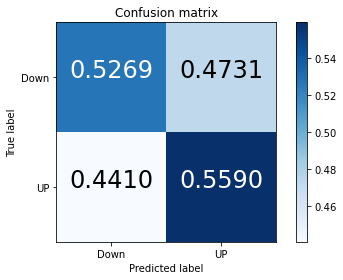

In [338]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['Down', 'UP']


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylim([1.5, -.5])

    fmt = '.4f' if normalize else 'd'

    thresh = cm.max() - 0.05
    #plt.text(j, i, format(cm[i, j], fmt),

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #print (cm[i, j])
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 fontsize=24, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix

train_cnf_matrix = np.array([[88, 71], [79, 90]]).T
#eval_cnf_matrix = np.array([[27, 25], [3, 15]]).T
np.set_printoptions(precision=2)


# Set model for saving purposes

model = 'ARIMA'


# Plot normalized confusion matrix

plt.figure()

plot_confusion_matrix(train_cnf_matrix, classes=class_names, normalize=True)

plt.tight_layout()
plt.show()

# LSTM MODEL

In [173]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [174]:
import tensorflow as tf

In [175]:
# df = pd.read_csv("stock_data/GOOGL.csv")
# df=df.set_index('Date')


In [339]:
df=get_technical_indicators(df).dropna()
df=df.reset_index(drop=True)

In [340]:
#train test split
TRAIN_SPLIT=np.int(len(df)*0.8)

In [341]:
df_train=df[:TRAIN_SPLIT]
df_test =df[TRAIN_SPLIT:]
# df[:n][['close']].rename(columns={'close':'original trade close'}).plot.hist(bins=100, fontsize=12)
# df_train.rename(columns={'close':'scaled trade close'}).plot.hist(bins=100, fontsize=12)
# plt.show()

In [342]:
#Variables for training
cols = ['high', 'low', 'close', 'MA7', 'MA21', '20SD', 'upper_band', 'lower_band', 'EMA']

#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Volume']

['high', 'low', 'close', 'MA7', 'MA21', '20SD', 'upper_band', 'lower_band', 'EMA']


In [343]:
#New dataframe with only training data - 5 columns
df_for_training = df_train[cols].astype(float).dropna()
df_for_testing = df_test[cols].astype(float).dropna()

In [344]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)# array of scaled data


In [345]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing)
df_for_testing_scaled = scaler.transform(df_for_testing)# array of scaled data

In [346]:
#as required by lstm we reshape our data into sample, timestamp, features
#the n_features is 9. We will make timesteps = 20 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 20  # Number of past days we want to use to predict the future.


In [347]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY= np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (1288, 20, 9).
trainY shape == (1288, 1).


In [348]:
testX = []
testY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 20 # Number of past days we want to use to predict the future.


In [349]:
for j in range(n_past, len(df_for_testing_scaled) - n_future +1):    
    testX.append(df_for_testing_scaled[j - n_past:j, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[j + n_future - 1:j + n_future, 0])

testX, testY = np.array(testX), np.array(testY)
    
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))        

testX shape == (308, 20, 9).
testY shape == (308, 1).


In [369]:
from tensorflow import keras
from tensorflow.keras import layers

model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
#model.add(LSTM(16, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(8, activation='relu'))#, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 20, 16)            1664      
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_21 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 2,473
Trainable params: 2,473
Non-trainable params: 0
_________________________________________________________________


In [370]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
73/73 [==============================] - 1s 8ms/step - loss: 0.2781 - val_loss: 0.3981
Epoch 2/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0901 - val_loss: 0.2092
Epoch 3/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0783 - val_loss: 0.6156
Epoch 4/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0788 - val_loss: 0.6160
Epoch 5/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0651 - val_loss: 0.4247
Epoch 6/50
73/73 [==============================] - 0s 6ms/step - loss: 0.0591 - val_loss: 0.8842
Epoch 7/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.5789
Epoch 8/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0643 - val_loss: 0.3044
Epoch 9/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0627 - val_loss: 0.6751
Epoch 10/50
73/73 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.3966
Epoch 11/50
73/73 [

In [371]:
#scaleback testing data
ytest_copies = np.repeat(testY, df_for_testing.shape[1], axis=-1)
y_test = scaler.inverse_transform(ytest_copies)[:,0]


In [372]:
#make predictions on he test data
prediction = model.predict(testX)

In [373]:

#scaleback prediction
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


In [374]:
# code up movements from previous day as 1 and down as 0

a = np.zeros(len(y_pred_future))
#a = []
a[0] = 1
for i in range(len(y_pred_future) - 1):
    #print(y_pred_future[i],y_pred_future[i+1])
    if y_pred_future[i+1]> y_pred_future[i]:
        #print(y_pred_future[i],y_pred_future[i+1])
        a[i+1] = 1


In [375]:

# code up movements from previous day as 1 and down as 0
b = np.zeros(len(y_test))
#a = []
b[0] = 1
for i in range(len(y_test) - 1):
    #print(y_pred_future[i],y_pred_future[i+1])
    if y_test[i+1]>y_test[i]:
        #print(testY[i],testY[i+1])
        b[i+1] = 1

In [378]:
#compare and store the counts of up and downs in test and prediction

up_r_up_pred=0
up_r_down_pred=0
d_r_up_pred=0
d_r_down_pred=0
for i in range(len(a)):
    #for j in range(len(b)):
    if a[i]==1 and b[i]==1:
        up_r_up_pred = up_r_up_pred + 1
        
#print(up_r_up_pred)
    elif a[i]==1 and b[i]==0:
        up_r_down_pred=up_r_down_pred+1
    elif a[i]==0 and b[i]==1:
        d_r_up_pred=d_r_up_pred+1
    elif a[i]==0 and b[i]==0:
        d_r_down_pred=d_r_down_pred+1

print("Up Real Up Prediction:"+str(up_r_up_pred))
print("Up Real Down Prediction:"+str(up_r_down_pred))
print("Down Real Up Prediction:" + str(d_r_up_pred))
print("Down Real Down Prediction:" + str(d_r_down_pred))

Up Real Up Prediction:104
Up Real Down Prediction:72
Down Real Up Prediction:46
Down Real Down Prediction:86


Normalized Confusion Matrix
[[0.54 0.46]
 [0.31 0.69]]


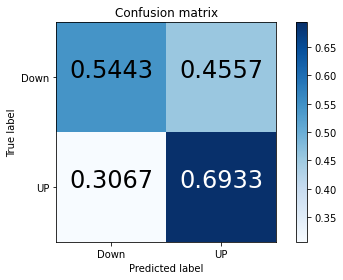

In [377]:
import itertools
import numpy as np
import matplotlib.pyplot as plt


from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['Down', 'UP']


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylim([1.5, -.5])

    fmt = '.4f' if normalize else 'd'

    thresh = cm.max() - 0.05
    #plt.text(j, i, format(cm[i, j], fmt),

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #print (cm[i, j])
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 fontsize=24, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix

train_cnf_matrix = np.array([[86, 46], [72, 104]]).T
#eval_cnf_matrix = np.array([[27, 25], [3, 15]]).T
np.set_printoptions(precision=2)


# Set model for saving purposes

model = 'LSTM'


# Plot normalized confusion matrix

plt.figure()

plot_confusion_matrix(train_cnf_matrix, classes=class_names, normalize=True)

plt.tight_layout()
plt.show()